In [128]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import pandas as pd
import os
import glob
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [138]:
i = 0
traces = 5
target = 'finger_x'
df_full_data = None

root = '/Users/danielnoble/Downloads/data_GP/KY'

for folder in os.listdir(root):
    pattern = os.path.join(root, folder, '*.csv')
    csv_files = glob.glob(pattern)
    
    if (csv_files):
        csv, = csv_files
        if isinstance(df_full_data, pd.DataFrame):
            df_full_data = pd.concat([df_full_data, pd.read_csv(csv)])
        else:
            df_full_data = pd.read_csv(csv)
        
        if (i == 0):
            trace_1 = pd.read_csv(csv)
        elif (i == 1):
            trace_2 = pd.read_csv(csv)
        elif(i == 2):
            trace_3 = pd.read_csv(csv)
        elif (i == 3):
            trace_4 = pd.read_csv(csv)
        elif (i == 4):
            trace_5 = pd.read_csv(csv)
        i += 1

df_traces = df_full_data[['frame', target]].copy()
df = pd.DataFrame(columns = ['frame', target])

# choose random values from the 5 traces 
for i in range(df_traces.index.max()):
    df = df.append(df_traces.loc[i, :].sample())
print(df)

     frame  finger_x
0        0 -0.289697
1        1 -0.258253
2        2 -0.274376
3        3 -0.259360
4        4 -0.259972
...    ...       ...
1024  1024 -0.385565
1025  1025 -0.617948
1026  1026 -0.264305
1027  1027 -0.497978
1028  1028 -0.623221

[1029 rows x 2 columns]


In [139]:
# Find the global kernel

sigma_f = 7
sigma_l = 100
sigma_n = 1
num_samples = 1030

# take 1 of every 20 points for dataset
x_data = df.loc[::20, 'frame'].to_numpy().reshape(-1, 1)
y_data = df.loc[::20, target].to_numpy().reshape(-1, 1)

# fit Gaussian process
Kernel = sigma_f ** 2 * RBF(length_scale = sigma_l) + WhiteKernel(noise_level = sigma_n ** 2)
gpr = GaussianProcessRegressor(kernel = Kernel).fit(x_data, y_data)

# find the global parameters and log marginal likelihood
pars = gpr.kernel_.get_params()
global_pars = (pars['k1__k1'], pars['k1__k2'].length_scale, pars['k2'].noise_level)
global_LML = gpr.log_marginal_likelihood()
print(global_LML)

# prediction
x_axis = np.linspace(0, num_samples, num_samples)
y_mean, y_cov = gpr.predict(x_axis[:, np.newaxis], return_cov = True)

49.48189249428893


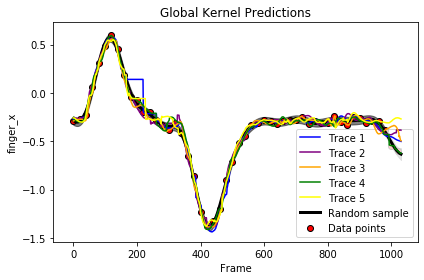

In [140]:
# Plot global kernel prediction
plt.title('Global Kernel Predictions')
plt.xlabel('Frame')
plt.ylabel(target)

plt.plot(x_axis, trace_1[target], zorder = 10, c = 'blue', label = 'Trace 1')
plt.plot(x_axis, trace_2[target], zorder = 10, c = 'purple', label = 'Trace 2')
plt.plot(x_axis, trace_3[target], zorder = 10, c = 'orange', label = 'Trace 3')
plt.plot(x_axis, trace_4[target], zorder = 10, c = 'green', label = 'Trace 4')
plt.plot(x_axis, trace_5[target], zorder = 10, c = 'yellow', label = 'Trace 5')

plt.plot(x_axis, y_mean, lw = 3, zorder = 9, c = 'k', label = 'Random sample')
plt.fill_between(x_axis, y_mean[:, 0] - np.sqrt(np.diag(y_cov)),
                 y_mean[:, 0] + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.scatter(x_data, y_data, c='r', edgecolors=(0, 0, 0), label = 'Data points')
plt.tight_layout()
plt.legend(loc = 'lower right')


In [159]:
# Find local kernels 
sigma_f = .1
sigma_l = .08
sigma_n = -.2

window = 50
delta = 10
position = 0
local_pars = []
num_windows = 0
local_LML = 0

data = df.copy()
data_local = pd.DataFrame(columns = ['frame', 'total_mean', 'kernels'])
data_local['frame'] = np.arange(num_samples)
data_local['total_mean'] = np.array([0] * num_samples)
data_local['kernels'] = np.array([0] * num_samples)
mean_vals = data_local['frame'].to_numpy().reshape(-1, 1)
counter = 0
while (position + window <= num_samples):
    x_data = data.loc[position : position + window - 1, 'frame'].to_numpy().reshape(-1, 1)
    y_data = data.loc[position : position + window - 1, target].to_numpy().reshape(-1, 1)

    # fit gaussian process for local kernel
    Kernel = sigma_f ** 2 * RBF(length_scale = sigma_l) + WhiteKernel(noise_level = sigma_n ** 2)
    gpr = GaussianProcessRegressor(kernel = Kernel).fit(x_data, y_data)
    
    # find and store the hyperparameters and log marginal likelihood
    pars = gpr.kernel_.get_params()
    f, l, n = pars['k1__k1'], pars['k1__k2'].length_scale, pars['k2'].noise_level
    local_pars.append((f, l, n))
    num_windows += 1
    local_LML = (local_LML + gpr.log_marginal_likelihood()) / num_windows
    
    # prediction
    x_axis = np.linspace(position, position + window, window)
    y_mean, y_cov = gpr.predict(x_axis[:, np.newaxis], return_cov = True)
    counter += 1
    y_mean = y_mean.squeeze()
    
    print(y_mean)
    print(data_local.loc[position : position + window - 1, 'total_mean'])
    data_local.loc[position : position + window - 1, 'total mean'] = \
    data_local.loc[position : position + window - 1, 'total_mean'].to_numpy() + y_mean
    print(data_local.loc[position : position + window - 1, 'total_mean'])
    print()
    
    data_local.loc[position : position + window - 1, 'kernels'] = \
    data_local.loc[position : position + window - 1, 'kernels'].to_numpy() + np.array([1] * window)
    
    position += delta

[-4.86101601e-02 -4.19467188e-02 -4.04206745e-02 -3.24716801e-02
 -2.59184756e-02 -1.94488018e-02 -1.34839491e-02 -9.38464938e-03
 -5.41187918e-03 -3.30856466e-03 -1.77979399e-03 -8.96762449e-04
 -4.04405152e-04 -1.94475730e-04 -8.15917373e-05 -2.94943057e-05
 -1.10787186e-05 -3.72067374e-06 -1.18777565e-06 -3.54986265e-07
 -1.00838958e-07 -2.60859814e-08 -7.28214297e-09 -1.70603946e-09
 -3.95514940e-10 -3.85992478e-10 -1.67977763e-09 -6.63375514e-09
 -2.85769673e-08 -1.12016722e-07 -3.67215535e-07 -1.25188391e-06
 -3.46347752e-06 -1.16255489e-05 -3.14678971e-05 -7.12296750e-05
 -1.97737711e-04 -3.70677270e-04 -7.98773832e-04 -1.47981305e-03
 -2.57392312e-03 -3.77931051e-03 -5.59795241e-03 -8.32549246e-03
 -1.57144972e-02 -9.78862843e-03 -1.12534930e-02 -1.15577743e-02
 -9.97658733e-03 -1.21298914e-36]
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23

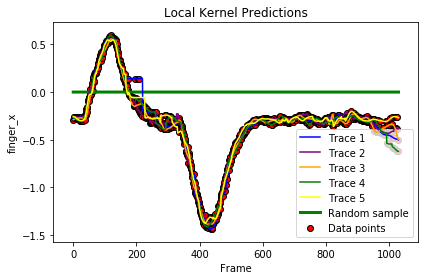

In [152]:
# Plot local kernel predictions

x = data['frame'].to_numpy().reshape(-1, 1)
y = data[target].to_numpy().reshape(-1, 1)
x_axis = np.linspace(0, num_samples, num_samples)
y_mean = data_local['total_mean'].to_numpy() / data_local['kernels'].to_numpy()

plt.clf()
plt.title('Local Kernel Predictions')
plt.ylabel(target)
plt.xlabel('Frame')

plt.plot(x_axis, trace_1[target], zorder = 10, c = 'blue', label = "Trace 1")
plt.plot(x_axis, trace_2[target], zorder = 10, c = 'purple', label = "Trace 2")
plt.plot(x_axis, trace_3[target], zorder = 10, c = 'orange', label = "Trace 3")
plt.plot(x_axis, trace_4[target], zorder = 10, c = 'green', label = "Trace 4")
plt.plot(x_axis, trace_5[target], zorder = 10, c = 'yellow', label = "Trace 5")
plt.plot(x_axis, y_mean, lw = 3, zorder = 9, c ='g', label = 'Random sample')

plt.scatter(x, y, c='r', edgecolors=(0, 0, 0), label = 'Data points')
plt.tight_layout()
plt.legend(loc = 'lower right')

LML for global kernel = 49.48189249428893
LML for local kernel = -0.29579092107050176


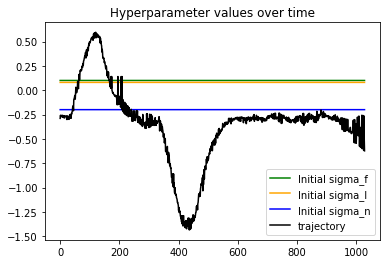

In [150]:
# compare the global and local kernel log marginal likelihood
print(f'LML for global kernel = {global_LML}')
print(f'LML for local kernel = {local_LML}')

# plot hyperparameter values
plt.title('Hyperparameter values over time')
plt.plot(x, [sigma_f] * len(x), c = 'green', label = 'Initial sigma_f')
plt.plot(x, [sigma_l] * len(x), c = 'orange', label = 'Initial sigma_l')
plt.plot(x, [sigma_n] * len(x), c = 'blue', label = 'Initial sigma_n')
plt.plot(x, y, c = 'black', label = 'trajectory')
plt.legend(loc = 'lower right')

In [161]:
sigmaF = []
sigmaL = []
sigmaN = []
for i in range(counter):
    sigmaF.append(local_pars[i][0])
    sigmaL.append(local_pars[i][1])
    sigmaN.append(local_pars[i][2])

print(sigmaF)
print()
print(sigmaL)
print()
print(sigmaN)
print()

[0.104**2, 0.1**2, 0.0965**2, 0.0947**2, 0.0989**2, 0.107**2, 0.135**2, 0.179**2, 0.422**2, 0.274**2, 0.437**2, 0.354**2, 0.157**2, 0.112**2, 0.0977**2, 0.0821**2, 0.0671**2, 0.0774**2, 0.0846**2, 0.0937**2, 0.0986**2, 0.101**2, 0.104**2, 0.107**2, 0.11**2, 0.113**2, 0.116**2, 0.119**2, 0.119**2, 0.117**2, 0.124**2, 0.158**2, 0.386**2, 0.213**2, 0.303**2, 0.445**2, 0.0927**2, 0.11**2, 0.0411**2, 0.0622**2, 0.0527**2, 0.0521**2, 0.0583**2, 0.0429**2, 0.114**2, 0.0992**2, 0.0786**2, 0.375**2, 0.273**2, 0.215**2, 0.274**2, 0.35**2, 0.171**2, 0.142**2, 0.126**2, 0.116**2, 0.112**2, 0.109**2, 0.109**2, 0.108**2, 0.109**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.107**2, 0.107**2, 0.106**2, 0.106**2, 0.107**2, 0.108**2, 0.109**2, 0.11**2, 0.11**2, 0.11**2, 0.11**2, 0.109**2, 0.108**2, 0.108**2, 0.108**2, 0.107**2, 0.106**2, 0.107**2, 0.106**2, 0.106**2, 0.107**2, 0.107**2, 0.108**2, 0.112**2, 0.116**2, 0.127**2, 0.14**2, 0.152**2, 0.161**2, 0.18**2, 0.176**2]



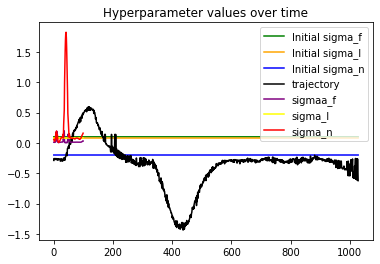

In [166]:
sigF = [0.104**2, 0.1**2, 0.0965**2, 0.0947**2, 0.0989**2, 0.107**2, 0.135**2, 0.179**2, 0.422**2, 0.274**2, 0.437**2, 0.354**2, 0.157**2, 0.112**2, 0.0977**2, 0.0821**2, 0.0671**2, 0.0774**2, 0.0846**2, 0.0937**2, 0.0986**2, 0.101**2, 0.104**2, 0.107**2, 0.11**2, 0.113**2, 0.116**2, 0.119**2, 0.119**2, 0.117**2, 0.124**2, 0.158**2, 0.386**2, 0.213**2, 0.303**2, 0.445**2, 0.0927**2, 0.11**2, 0.0411**2, 0.0622**2, 0.0527**2, 0.0521**2, 0.0583**2, 0.0429**2, 0.114**2, 0.0992**2, 0.0786**2, 0.375**2, 0.273**2, 0.215**2, 0.274**2, 0.35**2, 0.171**2, 0.142**2, 0.126**2, 0.116**2, 0.112**2, 0.109**2, 0.109**2, 0.108**2, 0.109**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.108**2, 0.107**2, 0.107**2, 0.106**2, 0.106**2, 0.107**2, 0.108**2, 0.109**2, 0.11**2, 0.11**2, 0.11**2, 0.11**2, 0.109**2, 0.108**2, 0.108**2, 0.108**2, 0.107**2, 0.106**2, 0.107**2, 0.106**2, 0.106**2, 0.107**2, 0.107**2, 0.108**2, 0.112**2, 0.116**2, 0.127**2, 0.14**2, 0.152**2, 0.161**2, 0.18**2, 0.176**2]
sigL = [0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999, 0.07999999999999999]
sigN = [0.05377750914478973, 0.040755298970870844, 0.03042931130640982, 0.02659155013352372, 0.036508958268953895, 0.06719242145520958, 0.11423491870825551, 0.15865149813661802, 0.06418806360240922, 0.19593179186919746, 0.06883985658626986, 0.09224821726740648, 0.1341855285418142, 0.08383004901394496, 0.03330700775416937, 0.012511754356623826, 0.006715354122776027, 0.00998386958210057, 0.014444072709824476, 0.02452405513949682, 0.03565173935093399, 0.044706706005416944, 0.05256823158890375, 0.0672938844698255, 0.07892098277095426, 0.08434831486277579, 0.0905588191442979, 0.09439761756381479, 0.09409743994724307, 0.09082808646460876, 0.10227569731756136, 0.13475864486315897, 0.07985546295128937, 0.3022906351564254, 0.42667210021248775, 0.5386656207841877, 0.9866259527158708, 1.250427245229826, 1.5050705533811284, 1.6929989650579054, 1.8060452653665464, 1.8245478555838697, 1.7361424503807625, 1.5590775701756985, 1.324954375626757, 1.0751187045427413, 0.8236123647527795, 0.4851383253811076, 0.3950750334607545, 0.30532849602560497, 0.1981206590963268, 0.09374425600739712, 0.14367997987211814, 0.1220551291663077, 0.103817527313626, 0.08988665084896172, 0.08218891355959358, 0.07733846742464075, 0.076651275919079, 0.07531195513987504, 0.07597436900432127, 0.07498506028916256, 0.07460028642895647, 0.07298832562321846, 0.07408143137981568, 0.07506677285419927, 0.07381646839681068, 0.07140687619662162, 0.06826142020905479, 0.06668344416924064, 0.06505495153555413, 0.06489763833890469, 0.06827718391044564, 0.07346817494539302, 0.07638790415960467, 0.07800880257914196, 0.07961841180742896, 0.07902470251980462, 0.07908502040516063, 0.076400286477039, 0.07356614232102256, 0.07412657373616277, 0.07382408204700487, 0.06894487788296194, 0.06434111874789387, 0.06180302315807282, 0.05926270924936748, 0.05952544464701373, 0.061412887206745925, 0.06808044614888646, 0.07394031354617459, 0.08218325461885335, 0.09069621059685559, 0.10507049045492176, 0.11957846872455626, 0.13012445645776938, 0.1370154144666737, 0.14879648597201695, 0.16008404560194253]
x_axis = np.linspace(0, counter, counter)

plt.title('Hyperparameter values over time')
plt.plot(x, [sigma_f] * len(x), c = 'green', label = 'Initial sigma_f')
plt.plot(x, [sigma_l] * len(x), c = 'orange', label = 'Initial sigma_l')
plt.plot(x, [sigma_n] * len(x), c = 'blue', label = 'Initial sigma_n')
plt.plot(x, y, c = 'black', label = 'trajectory')
plt.plot(x_axis, sigF, c = 'purple', label = 'sigmaa_f')
plt.plot(x_axis, sigL, c = 'yellow', label = 'sigma_l')
plt.plot(x_axis, sigN, c = 'red', label = 'sigma_n')
plt.legend(loc = 'upper right')
plt.show()